## Now we will extract a larger region of around 2000 kms surrounding the Noctis Mons

### 1. Loading the Mola grid and Extracting the map of desired extent

In [1]:
import geopandas as gpd
import numpy as np 
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})  
import pyshtools as pysh
from scipy.interpolate import Rbf
from scipy.interpolate import RBFInterpolator
import pyshtools as pysh
from shapely.geometry import box, LineString, MultiLineString

#Loading files
base_layer = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\base elevations_2.shp")
raised_layer = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\raised elevations_2.shp") 
#FROM ATTRIBUTE TABLE
x_b = base_layer['X'].values
y_b = base_layer['Y'].values
z_b = base_layer['elevations'].values

#-------Load MOLA spherical harmonic coefficients---------------# 
mola_sh = pysh.datasets.Mars.MOLA_shape(lmax = 3000)    #Use lmax = 3000 in brackets for to download the entire dataset with 3000 degree, without this th elater expansion will stretch the aailable data hecne the pixelised appearance.
mola_sh.coeffs[0,0,0] = 0 #mean planetary radius
mola_sh.coeffs[0,2,0] = 0 #C20 component 
#expansion: transforming from spherical harmonic coefficients into a spatial grid representation so ---> this expands the data from spherical harmonic space to physical space (a global grid of elevation values).
mola_grid_obj = mola_sh.expand(grid='DH')  
mola_grid = mola_grid_obj.data                       

lat_mola = mola_grid_obj.lats() 
lon_mola = mola_grid_obj.lons() 

# desired extent (manually identifed a region extedning 2000 km around noctis) 

lon_min, lon_max = (-111.37 + 360),(-82.5 + 360)  #clicked manually on the map #(convert longitude to 0–360 range for DH grid)
lat_min, lat_max = (-20), (5)      

#these latitudes are identified in the gloabl grid and then based on their indices are extracted out. 

lon_inds = np.where((lon_mola >= lon_min) & (lon_mola <= lon_max))[0] #since np.where returns a tuple, we need to get an array out of it by using [0]
lat_inds = np.where((lat_mola >= lat_min) & (lat_mola <= lat_max))[0] #since first element of every tuple is an array in fact 

# Extract the desired grid
grid_noctis_2000 = mola_grid[np.ix_(lat_inds, lon_inds)]
print("At this extent the Noctis2000 MOLA grid shape is:", grid_noctis_2000.shape)

#we can make an equally spaced list of minimum and maximum coordinates 
longitudes_extent = np.linspace(lon_min, lon_max, num = grid_noctis_2000.shape[1])
latitudes_extent = np.linspace(lat_min, lat_max, num= grid_noctis_2000.shape[0])

ext_gdf  = gpd.read_file("extedatafaults.geojson")
comp_gdf = gpd.read_file("compdatafaults.geojson")

def shift_longitudes(geom):
    # same shift function we already have…
    if geom.geom_type == 'LineString':
        shifted = [(lon+360 if lon < 0 else lon, lat) for lon, lat in geom.coords]
        return LineString(shifted)
    elif geom.geom_type == 'MultiLineString':
        return MultiLineString([shift_longitudes(line) for line in geom.geoms])
    else:
        return geom

ext_gdf['geometry']  = ext_gdf.geometry.apply(shift_longitudes)
comp_gdf['geometry'] = comp_gdf.geometry.apply(shift_longitudes)

# shapely box for extents
bbox_poly = box(lon_min, lat_min, lon_max, lat_max)

#(this actually cuts the lines to the window, rather than selecting entire features)
ext_clip  = gpd.clip(ext_gdf,  bbox_poly)
comp_clip = gpd.clip(comp_gdf, bbox_poly)

# dropping any empty geometries (fully outside)
ext_clip  = ext_clip[~ext_clip.geometry.is_empty]
comp_clip = comp_clip[~comp_clip.geometry.is_empty]

# 5. Plot as before
%matplotlib qt
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(
    grid_noctis_2000,
    origin='upper',
    cmap='terrain',
    extent=[lon_min, lon_max, lat_min, lat_max]
)
ext_clip.plot(ax=ax, linewidth=1, edgecolor='red',   label='Extended Faults')
comp_clip.plot(ax=ax, linewidth=1, edgecolor='blue',  label='Compressional Faults')

ax.set(xlabel="Longitude (°E)", ylabel="Latitude (°N)",
       title="Noctis Region MOLA Elevation + Fault Lines")
ax.legend(loc='lower right')
plt.colorbar(ax.images[0], ax=ax, label='Elevation (m)')
plt.show()


At this extent the Noctis2000 MOLA grid shape is: (833, 481)


### Here we define a lower resolution grid to perform interpolation later to avoid negative values in the thickness grid
#### Just changing the lmax_calc can keep the shape while changing the resolution. Easy insertion afterwards

### Elevation profiles 

#### Objective: to see where noctis bulge begins

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Mars mean radius in km
R_mars = 3389.5

#—– Your existing grid & map setup variables must be defined before this:
# longitudes_extent, latitudes_extent, grid_noctis_2000
# lon_min, lon_max, lat_min, lat_max
# ext_clip, comp_clip

# Noctis Center (geographical coordinates)
noctis_center_lon = -94.60 + 360  # wrap to 0–360°
noctis_center_lat = -7.05

# Find the grid indices corresponding to Noctis Center
noctis_center_x = np.argmin(np.abs(longitudes_extent - noctis_center_lon))
noctis_center_y = np.argmin(np.abs(latitudes_extent - noctis_center_lat))

# Profile orientation (azimuthal angle in degrees)
angle = 80  

# Profile length in grid units
length = 1000  
dx = length * np.cos(np.radians(angle))
dy = length * np.sin(np.radians(angle))

# Compute start & end indices for the diagonal profile
x_start = int(noctis_center_x - dx / 2)
y_start = int(noctis_center_y - dy / 2)
x_end   = int(noctis_center_x + dx / 2)
y_end   = int(noctis_center_y + dy / 2)

# Build index arrays along the line (clipped to grid bounds)
x_indices_profile = np.clip(
    np.linspace(x_start, x_end, num=length),
    0, grid_noctis_2000.shape[1]-1
).astype(int)
y_indices_profile = np.clip(
    np.linspace(y_start, y_end, num=length),
    0, grid_noctis_2000.shape[0]-1
).astype(int)

# Extract elevations along the profile
elevation_profile = grid_noctis_2000[y_indices_profile, x_indices_profile]

# ---------------------------------------------------
# Convert grid steps to true along‐surface distance (km)
# ---------------------------------------------------
lons = longitudes_extent[x_indices_profile]
lats = latitudes_extent[y_indices_profile]
lons_rad = np.radians(lons)
lats_rad = np.radians(lats)

# Cumulative great‐circle distance
distances_km = np.zeros(length)
for i in range(1, length):
    dlat = lats_rad[i] - lats_rad[i-1]
    dlon = lons_rad[i] - lons_rad[i-1]
    a = (
        np.sin(dlat/2)**2 +
        np.cos(lats_rad[i-1]) * np.cos(lats_rad[i]) * np.sin(dlon/2)**2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distances_km[i] = distances_km[i-1] + R_mars * c

# ---------------------------------------------------
# Plot the Map and the Elevation Profile in km
# ---------------------------------------------------
fig, axes = plt.subplots(2,1, figsize=(15, 9))
ax1, ax2 = axes

# Map view with profile overlay
im1 = ax1.imshow(
    grid_noctis_2000,
    origin='upper',
    cmap='terrain',
    extent=[lon_min, lon_max, lat_min, lat_max],
    alpha=0.8
)
ax1.contour(
    longitudes_extent,
    latitudes_extent,
    grid_noctis_2000[::-1],
    levels=5,
    colors='black',
    linewidths=0.5,
    origin='lower'
)
ax1.plot(
    lons,
    lats,
    color='cyan',
    linewidth=2,
    linestyle='--',
    label="Profile Line"
)
ext_clip.plot(ax=ax1, linewidth=2, edgecolor='red',   label='Extended Faults')
comp_clip.plot(ax=ax1, linewidth=1.5, edgecolor='blue',  label='Compressional Faults')
ax1.scatter([noctis_center_lon], [noctis_center_lat], color='red', marker='o', label="Noctis Center")
ax1.set_title("Diagonal Profile at 80°")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
fig.colorbar(im1, label="Elevation", location='left', aspect=20)
ax1.legend()

# Elevation profile vs. distance in km
ax2.plot(distances_km, elevation_profile, color='black', linewidth=2, label='Elevation')
ax2.fill_between(distances_km, elevation_profile, color='grey', alpha=0.1)
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Elevation (m)")
ax2.set_title("Elevation Profile along Diagonal Path")

# Highlighted uplift bounds (in grid units → convert to km)
highlight_min_km = distances_km[247]  # index 247
highlight_max_km = distances_km[904]  # index 904
ax2.axvspan(highlight_min_km, highlight_max_km, color='red', alpha=0.2,
            label="Uplift bounds")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()


One derivation from this profile could be that the longitudinal range of mons might be somehwere between 263 and 269.5 (from zoomed in

### - Since we are taking a mean elevation, we are introducing the vallis marineris elevation as low as -3000 in as much as 5 profiles at least so the mean profile 


### - Profiles going through valles marineris can be removed 

In [22]:
# Define Azimuth Angles for Profiles
azimuths = np.linspace(0, 180, num=35) #15 profiles between 0 and 180 equally spaced angles 
length = 1000 #(in grid in units)  

#let us try to remove the angles passing thrugh valles marineris for better constraint on heights
# Remove angles in the range [0, 70]
azimuths = azimuths[(azimuths < 0) | (azimuths > 70) & (azimuths < 115) | (azimuths > 180)]

#containers to store values
elevation_profiles = []
profile_lons = [] #stores longitudes of each profile line 
profile_lats = [] #stores latitudes of each proifle line

fig, ax = plt.subplots(figsize=(12,6))
im1 = ax.imshow(grid_noctis_2000,
                origin='upper',
                cmap='terrain',
                extent=[lon_min, lon_max, lat_min, lat_max])

ax = plt.gca()
ext_clip.plot(ax=ax, linewidth=2, edgecolor='red', label='extensional Faults')
comp_clip.plot(ax=ax, linewidth=2, edgecolor='blue', label='compressional Faults')

ax.contour(longitudes_extent, latitudes_extent, grid_noctis_2000[::-1], levels=5, colors='black', linewidths=0.5, origin = 'upper')
ax.scatter([noctis_center_lon], [noctis_center_lat], color='red', marker='o', label="Noctis Center")

# Loops through each azimuth to compute and plot profiles
for angle in azimuths:
    dx = length * np.cos(np.radians(angle))
    dy = length * np.sin(np.radians(angle))
    
    x_start = int(noctis_center_x - dx / 2)
    y_start = int(noctis_center_y - dy / 2)
    x_end = int(noctis_center_x + dx / 2)
    y_end = int(noctis_center_y + dy / 2)
    
    x_indices_profile = np.clip(np.linspace(x_start, x_end, num=length), 0,  grid_noctis_2000.shape[1] - 1).astype(int)
    y_indices_profile = np.clip(np.linspace(y_start, y_end, num=length), 0, grid_noctis_2000.shape[0] - 1).astype(int)
    
    elevation_profile = grid_noctis_2000[y_indices_profile, x_indices_profile]
    elevation_profiles.append(elevation_profile)  # appends to store profiles in the container/list above 
    
    # computes the *geographic* coords for this specific profile line being processed in the loop
    lons = longitudes_extent[x_indices_profile]
    lats = latitudes_extent[y_indices_profile]
    profile_lons.append(lons)
    profile_lats.append(lats)
    
    # Plot profile on the map
    ax.plot(lons, lats, '--', linewidth=1.2, label=f"{angle:.1f}°")
    #plt.plot(longitudes_extent[x_indices_profile], latitudes_extent[y_indices_profile], linewidth=1.5, linestyle='--', label=f"{angle:.1f}°")

# converts to NumPy array
elevation_profiles = np.array(elevation_profiles)

# compute Mean Elevation Profile
average_elevation_profile = np.mean(elevation_profiles, axis=0)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Elevation profiles over present-day Noctis")
plt.colorbar(im1, label="Elevation", location='right', pad = 0.02)

# ——— now the interactive bit —-
click_dists = []
highlight_min_1 = None
highlight_max_1 = None


def on_click(event):
    global highlight_min_1, highlight_max_1

    if event.inaxes is not ax:
        return
    lon_c, lat_c = event.xdata, event.ydata
    
    # find the *single* closest (profile, index) pair
    best = {'d2': np.inf}
    for i, (lons, lats) in enumerate(zip(profile_lons, profile_lats)):
        # squared distance to every point on that profile
        d2 = (lons - lon_c)**2 + (lats - lat_c)**2
        j = np.argmin(d2)
        if d2[j] < best['d2']:
            best.update(profile=i, idx=j, d2=d2[j])

    # recover the matching distance along that profile
    matched_dist = distance_values[best['idx']]
    print(f">> Clicked at ({lon_c:.3f}, {lat_c:.3f}); "
          f"nearest profile {azimuths[best['profile']]:.1f}° "
          f"→ distance = {matched_dist:.2f}")

    # store it (e.g. to define two bounds by two clicks…)
    click_dists.append(matched_dist)

    # optionally annotate the click on the map
    ax.plot(lon_c, lat_c,
        marker='x',
        color='k',
        markersize=10,    # controls the size of the symbol
        markeredgewidth=3 # controls the thickness of the “x” lines
       )
    fig.canvas.draw()

    # once you have two clicks, you can assign highlight_min_1, highlight_max_1:
    if len(click_dists) == 2:
        highlight_min_1, highlight_max_1 = sorted(click_dists)
        print(f"  → setting highlight_min_1 = {highlight_min_1:.2f}, "
              f"highlight_max_1 = {highlight_max_1:.2f}")
        # you could now re‑draw your profile figure with those new bounds…
        # or just copy these into your next block of code and re‑run it.

# hook up the click
fig.canvas.mpl_connect('button_press_event', on_click)
plt.legend(markerscale=0.5, fontsize=12, loc='lower left')
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Elevation profiles over present-day Noctis (distances in km)")
plt.colorbar(im1, label="Elevation")
plt.legend(markerscale=0.5, fontsize=12, loc='lower left')
plt.show()


>> Clicked at (266.852, -3.225); nearest profile 79.4° → distance = 629.63
>> Clicked at (264.499, -10.206); nearest profile 84.7° → distance = 394.39
  → setting highlight_min_1 = 394.39, highlight_max_1 = 629.63


In [47]:
highlight_min_km = 2811.00
highlight_max_km = 4742.16 

In [25]:
# Plot Elevation Profiles
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
distance_values = np.linspace(0, length, num=length)

# Individual Elevation Profiles
for i, angle in enumerate(azimuths):
    axes[0].plot(distance_values, elevation_profiles[i], linewidth=1.5, label=f'{angle:.1f}°')

axes[0].legend(fontsize=8)
axes[0].set_ylabel("Elevation (m)")
axes[0].set_xlabel("Distance (grid units)")
axes[0].set_title("Elevation Profiles over present day (eroded) Noctis Mons")
axes[0].grid(True)

# Mean Elevation Profile
axes[1].plot(distance_values, average_elevation_profile, color='black', linewidth=2, label='Mean Profile')
axes[1].fill_between(distance_values, average_elevation_profile, alpha=0.2, color='gray')
axes[1].set_ylabel("Elevation (m)")
axes[1].set_xlabel("Distance (grid units)")
axes[1].set_title("Mean Elevation Profiles over present day (eroded) Noctis Mons")
axes[1].grid(True)


# Shade the region in the elevation profile
axes[1].axvspan(highlight_min, highlight_max, color='red', alpha=0.2, label="Larger uplift bounds")
axes[1].set_ylim(0, 10000)
axes[0].axvspan(highlight_min, highlight_max, color='red', alpha=0.2, label="Larger uplift bounds")


axes[1].axvspan(highlight_min_1, highlight_max_1, color='yellow', alpha=0.2, label=f"Uplift bounds \nfrom extesnional tectonics")
axes[0].axvspan(highlight_min_1, highlight_max_1, color='yellow', alpha=0.2, label=f"Uplift bounds \nfrom extesnional tectonics")


axes[1].legend(loc='lower left')
axes[0].legend(fontsize=6)


plt.tight_layout()
plt.show()


In [27]:
from scipy.interpolate import UnivariateSpline

# ── 1) True km abscissa ──
x_km = distances_km  # already a 1:1 map from profile index → km

# ── 2) Define removal window in km (cast to int indices) ──
idx_min = int(highlight_min_1)
idx_max = int(highlight_max_1)
rem_min_km = distances_km[idx_min]
rem_max_km = distances_km[idx_max]

# ── 3) Mask out the removed section ──
mask_keep = (x_km < rem_min_km) | (x_km > rem_max_km)
x_keep = x_km[mask_keep]
y_keep = average_elevation_profile[mask_keep]

# ── 4) Sort & dedupe ──
sort_idx  = np.argsort(x_keep)
x_sorted  = x_keep[sort_idx]
y_sorted  = y_keep[sort_idx]
x_u, unique_idx = np.unique(x_sorted, return_index=True)
y_u = y_sorted[unique_idx]

# ── 5) Fit spline and fill gap ──
smoothing = 1e7
spl = UnivariateSpline(x_u, y_u, k=4, s=smoothing)

y_filled = average_elevation_profile.copy()
mask_remove = ~mask_keep
y_filled[mask_remove] = spl(x_km[mask_remove])

# ── 6) Plot in km ──
plt.figure(figsize=(10,5))
# kept sections
plt.plot(x_km[x_km < rem_min_km], average_elevation_profile[x_km < rem_min_km], 'k')
plt.plot(x_km[x_km > rem_max_km], average_elevation_profile[x_km > rem_max_km], 'k', label='original profile')
# spline curve
plt.plot(x_km, spl(x_km), color='orange', label=f'spline (s={smoothing:.0e})')
# highlight removed section
plt.axvspan(rem_min_km, rem_max_km, color='yellow', alpha=0.2, label='Removed Section')

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Uplift removed via spline on Mars profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Recompute the smoothed spline on the km axis
y_spline = spl(x_km)  # now spl is evaluated at true km distances

# 1) Build the trend line between the two end-points
trend = np.linspace(y_spline[0], y_spline[-1], num=length)

# 2) Subtract it to detrend
y_detrended = y_spline - trend

# 3) Check endpoints are zero
print(y_detrended[0], y_detrended[-1])  # should print 0.0, 0.0

# 4) Plot with km on the x-axis
plt.figure(figsize=(10,5))
plt.plot(x_km, y_spline, label='Original Smoothed Profile')

# To crop at what was grid-unit index 925:
idx_crop = int(925)
crop_km = distances_km[idx_crop]
mask = x_km < crop_km

plt.plot(x_km[mask], y_detrended[mask],
         label=f'Detrended (zero at ends) cropped at {crop_km:.1f} km')
plt.title("Sampled profile detrended to get uplift estimate")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.legend()
plt.grid(True)
plt.show()

# 5) Save everything (including km axis values)
np.savez(
    "uplift_spline_profile_tectonics.npz",
    x_km=x_km,
    y_spline=y_spline,
    y_detrended=y_detrended
)


0.0 0.0


## Interpolation: Low resolution interpolation (for better estimation)
## Masking out Noctis and Interpolating  without Noctis (wirth low_resolution)

### This shall give us a Pre-Noctis Elevtion (that is a plane with the bulged part removed out)

In [32]:
raised_layer = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\raised elevations_2.shp") 
x = raised_layer['X'].values +360
y = raised_layer['Y'].values
z = raised_layer['elevations'].values

#----Cropping out a circular region and interpolating the plane without it that is pre-noctis plane.

# lon_inds and lat_inds are the indices used to extract grid_noctis_2000
#lon_sub and lat_sub are indices used to extract a samller grid 
lon_sub_lr = lon_mola_lr[lon_inds_lr]
lat_sub_lr = lat_mola_lr[lat_inds_lr]
# Create 2D coordinate grids
lon_grid, lat_grid = np.meshgrid(lon_sub_lr, lat_sub_lr)
#The center longitude and latitude of the circular mask.
nm_lon_center, nm_lat_center = -94.60 + 360, -7.05  # center of the circle (manually identified)
#nm_radius = 3.199    #manually selected 
nm_radius = (269.5 - 262.70)/2 # (in degrees)--> Based on the bounds of uplift observed from the 80 degree elevation profile (noticebale uplift). 
# a boolean mask for Noctis Mons within the subgrid
#distance from each grid point to the centre
mask_nm_lr= np.sqrt((lon_grid - nm_lon_center)**2 + (lat_grid - nm_lat_center)**2) <= nm_radius
# Copy the original grid so as not to modify it directly
grid_noctis_masked_lr = grid_noctis_2000_lr.copy()
grid_noctis_masked_lr[mask_nm_lr] = np.nan
#This has given the noctis mons region a no-data (NaN) value
# Everything else is created as a mask of valid (non-NaN) data points
valid_mask_lr = ~np.isnan(grid_noctis_masked_lr)
# Extract coordinates and elevation values of valid points
points_valid_lr = np.array([lon_grid[valid_mask_lr], lat_grid[valid_mask_lr]]).T
values_valid_lr = grid_noctis_masked_lr[valid_mask_lr]
# all points in the grid where we want to interpolate
points_all_lr = np.array([lon_grid.ravel(), lat_grid.ravel()]).T


###------------ Interpolation either griddata methid or rbf----------###
np.random.seed(42) #any fixed number and what means is that same 4000 points will be selected each time and not different random points
sample_indices = np.random.choice(len(points_valid_lr), size=6000, replace=False)  # Adjust size based on memory
points_valid_lr = points_valid_lr[sample_indices]
values_valid_lr = values_valid_lr[sample_indices]

# Interpolate
#grid_filled_flat_lr = gpr.predict(points_all_lr)
#grid_noctis_filled_lr = grid_filled_flat_lr.reshape(grid_noctis_masked_lr.shape)

# Create RBF Interpolator

#grid_filled_flat_lr = griddata(points_valid_lr, values_valid_lr, points_all_lr, method='cubic')

rbf_interp = RBFInterpolator(points_valid_lr, values_valid_lr)  
# Interpolate for all grid points
grid_filled_flat_lr = rbf_interp(points_all_lr)  

###----------------Interpolation finished----------###
# Reshape back to the grid shape
grid_noctis_filled_lr = grid_filled_flat_lr.reshape(grid_noctis_masked_lr.shape)
### the idea is that we will interpolate a well estimated circlular region based on detected uplift above. This shall give us better constraint on the size of the region of interpolation here and later insertion.


#---the rectangular we will crop out of the Pre-Noctis will leave the Map carved out like this

lon_min_rectangular,lon_max_rectangular  = min(x), max(x)
lat_min_rectangular,lat_max_rectangular = min(y), max(y)
print(lon_min_rectangular, lat_min_rectangular)

rectangular_mask = np.zeros_like(mask_nm_lr, dtype=bool)

# Set the rectangular region to True within the calculated extents
rectangular_mask[
    (lon_grid >= lon_min_rectangular) & (lon_grid <= lon_max_rectangular) &
    (lat_grid >= lat_min_rectangular) & (lat_grid <= lat_max_rectangular)
] = True

# Apply the rectangular mask to the grid
grid_noctis_rectangular_masked = grid_noctis_2000.copy()
grid_noctis_rectangular_masked[rectangular_mask] = np.nan
# Everything else is created as a mask of valid (non-NaN) data points
valid_mask_rectangular = ~np.isnan(grid_noctis_rectangular_masked)

#---------------------Only for better understanding--------#

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

ax1, ax2, ax3 = axes[0], axes[1], axes [2]

#----------------- Plot of the grid with the masked region (Noctis Mons removed)--------#

im1 = ax1.imshow(grid_noctis_masked_lr, origin='upper', cmap='terrain',
                    extent=[lon_min, lon_max, lat_min, lat_max])
ax1.set_title("Grid with Noctis Mons Masked")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
fig.colorbar(im1, ax=ax1, orientation='horizontal', label="Elevation")

# Plot the grid after interpolation (Noctis Mons filled in)
im2 = ax2.imshow(grid_noctis_filled_lr, origin='upper', cmap='terrain',
                    extent=[lon_min, lon_max, lat_min, lat_max])
ax2.set_title("Interpolated Grid ('Pre-noctis Elevation Map')")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
fig.colorbar(im2, ax=ax2, orientation='horizontal', label="Elevation")                    

#the grid after masking out a rectangular part instead (in order to be able to use it for interpolation of highs)                     
im3 = ax3.imshow(grid_noctis_rectangular_masked, origin='upper', cmap='terrain',
                    extent=[lon_min, lon_max, lat_min, lat_max])
ax3.set_title("The rectangular mask cropped out from Pre-Noctis will leave this behind\n (to be used later for insertion)")
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
fig.colorbar(im3, ax=ax3, orientation='horizontal', label="Elevation")

plt.tight_layout()
plt.show()



262.8231152220798 -9.623771691479673


In [33]:
fig, ax1 = plt.subplots(1, figsize=(10, 8))
#ax1, ax2, ax3 = axes  # unpack the three Axes

# 1. Grid with Noctis Mons masked
im1 = ax1.imshow(grid_noctis_masked, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max])
ax1.set_title("Volcanic construct removed")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
fig.colorbar(im1, ax=ax1, location = 'right', label="Elevation")

# 2. Interpolated grid (Pre-Noctis elevation map)
im2 = ax2.imshow(grid_noctis_filled, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max])
ax2.set_title("Pre-Noctis uplifted plain")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
#fig.colorbar(im2, ax=ax2, location = 'right', label="Elevation")

# 3. Rectangular mask cropped from pre-Noctis map
im3 = ax3.imshow(grid_noctis_rectangular_masked, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max])
ax3.set_title(
    "Rectangular Mask Applied to Pre-Noctis Map\n(to be used later for insertion)"
)
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
#fig.colorbar(im3, ax=ax3, orientation='horizontal', label="Elevation")

plt.tight_layout()
plt.show()


In [34]:

import matplotlib.pyplot as plt

# 1. Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))  # you can adjust the size

# 2. Plot your array on that axis
im3 = ax.imshow(
    grid_noctis_filled_lr,
    origin='upper',
    cmap='terrain',
    extent=[lon_min, lon_max, lat_min, lat_max]
)

# 3. Add title and labels
ax.set_title("Interpolated Grid ('Pre-noctis Elevation Map')")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# 4. Add a colorbar
cbar = fig.colorbar(im3, ax=ax, orientation='vertical', label="Elevation")

# 5. Display the figure
plt.show()


### A pre-step: We want to put a geological context only over the interpolated region so we needed a new grid for that to match the extent and shape. For that we create a new grid to use as contour plot

#### Note: Remember to change the lon_mola and mola_grid variables depending on whether high resolution or low resolution grid is being used

In [35]:
x = raised_layer['X'].values +360
y = raised_layer['Y'].values
z = raised_layer['elevations'].values

lon_min_rect, lon_max_rect = min(x),max(x)  #clicked manually on the map #(convert longitude to 0–360 range for DH grid)
lat_min_rect, lat_max_rect = min(y), max(y)      

#these latitudes are identified in the gloabl grid and then based on their indices are extracted out. 

lon_inds_rect = np.where((lon_mola >= lon_min_rect) & (lon_mola<= lon_max_rect))[0] #this parses first element from lon_mola 
lat_inds_rect = np.where((lat_mola >= lat_min_rect) & (lat_mola <= lat_max_rect))[0]

# Extract the grid
grid_noctis_rect_elevation = mola_grid[np.ix_(lat_inds_rect, lon_inds_rect)]

print(" Because it is cut for the same extent from the same larger grid (grid_noctis_2000), the shape should match)\n Noctis rectangular MOLA grid shape ):", grid_noctis_rect_elevation.shape)


 Because it is cut for the same extent from the same larger grid (grid_noctis_2000), the shape should match)
 Noctis rectangular MOLA grid shape ): (175, 86)


## 1. Cropping a grid out from Pre-Noctis Elevation Map (low resolution, same shape)

Now we will carve out a rectangular area from the interpolated part above. This will aloows us to calculate thickness by subtracting form interpolated raised grid. 

We cannot have worked with circular grid for caclualtion. This is becasue we cannot use circular inteprolated region for caluclations later with the raised interpolated part since the rasied inteprolated grid is rectangular. 
it cannot be circular because the interpolation is complicated/does not work on circular extent grid (that is for raised ones). 

## 2. Interpolation of the raised points 
Simialr to what we did in previous notebook:except that this one will match the shape/resolution of the grid above  

## 3. Thickness grid or Uplift Grid (Inteprolated - Pre-noctis [cropped])

Out of the above two grids we can easily calculate the difference giving out a new grid representing in essence the uplift of the plane i.e., the bulge of the terrain as a whole induced indeed by the process that formed Noctis (i.e. Plume etc)

In [36]:
# Extents to extract from pre noctis elevation map (matching the extents of inteprolated raised grid whih is roughly thes aem as the circle excpet rectangular)
lon_min_crop, lon_max_crop = min(x), max(x)
lat_min_crop, lat_max_crop = min(y), max(y)
###----extracting the indices coorepsonding to the grid we want extracted-----##
#For longitude, we use np.searchsorted (assuming lon_sub is a sorted grid)
lon_idx_min = np.searchsorted(lon_sub_lr, min(x))
lon_idx_max = np.searchsorted(lon_sub_lr, max(x))

#for latitude we create a boolean mask for the latitude range
lat_mask = (lat_sub_lr >= min(y)) & (lat_sub_lr <= max(y))

# Note: np.where(lat_mask)[0] gives the indices of True values.
row_indices = np.where(lat_mask)[0]
if row_indices.size > 0:
    grid_noctis_cropped = grid_noctis_filled_lr[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max]
else:
    print("No latitude values found in the specified range!")

    
#---------Interpolation--------#
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), np.shape(grid_noctis_cropped)[1]),       
    np.linspace(min(y), max(y), np.shape(grid_noctis_cropped)[0]))
# Radial Basis Function (RBF) interpolation (Spline)

rbf_interpolator = Rbf(x, y, z, function='linear')
grid_z_spline_r = rbf_interpolator(grid_x, grid_y)

print(f'cropped grid shape: {grid_noctis_cropped.shape}')
print (f'Raised interpolation grid shape:{grid_z_spline_r.shape}')


#---Thickness or Uplift-----#

uplift_grid  = grid_z_spline_r - grid_noctis_cropped

#uplift_grid[uplift_grid<0] = 0

#-----------Plots  to verify---------#
fig, ax3 = plt.subplots(1, figsize=(10,8))

#ax1, ax2, ax3 = axes[0],axes[1],axes[2]


im1 = ax1.imshow(grid_noctis_cropped, origin='upper', cmap='terrain',
           extent=[min(x), max(x), min(y), max(y)])
ax1.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1], levels=2, colors='black', linewidths=0.5) #present day elevation for context
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("Uplifted Pre-Noctis ")
#fig.colorbar(im1, label="Elevation")


#can be either plotted as an image or as a contour
im2 = ax2.imshow(grid_z_spline_r, origin='upper', cmap='terrain', extent = [min(x), max(x),min(y), max(y)]) 
#im2 = ax2.contourf(grid_x, grid_y, grid_z_spline_r, levels=50, cmap = 'terrain')
ax2.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1], levels=2, colors='black', linewidths=0.5)
scatter = ax2.scatter(x, y, c='r', s=5)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Interpolated grid for raised elevations")
#fig.colorbar(im1, label="Elevation", location = 'right')


im3 = ax3.imshow(uplift_grid, origin='upper', cmap='terrain', extent=[min(x), max(x), min(y), max(y)])
#im3 = plt.contourf(grid_x, grid_y, uplift_grid, cmap='terrain', levels=50, origin = 'upper')
#geological context from the present day map (which in this case is grid_noctiss_2000 since we selcted a larger map)
ax3.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1], levels=2, colors='black', linewidths=0.5)
scatter = ax3.scatter(x, y, c='r', s=5, label = ' raised sample points')
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
ax3.set_title('Thickness Grid \n(raised surface - Pre-Noctis uplifted plain)')
fig.colorbar(im3, label = 'Elevation (m)')

plt.show()
print (f'Maximum uplifted point recorded:{np.max(uplift_grid)/1000} kms \n This will represent the highest elevation of the entire bulge')
print (f'Shape of the uplift grid: {uplift_grid.shape}')

np.save('uplift_grid.npy', uplift_grid)


cropped grid shape: (175, 86)
Raised interpolation grid shape:(175, 86)
Maximum uplifted point recorded:5.371858930617277 kms 
 This will represent the highest elevation of the entire bulge
Shape of the uplift grid: (175, 86)


## Insertion

#### Now we can insert the raised grid (interpolated raised grid) back into the larger region to get the larger context

### Inserting raised grid on the valid mask grid (just the one with rectangular shape cropped out) to see if the noctis mons stands out as a volcanic feature or just a number of many uplifted features? and then draw profiles over it 

In [41]:
print("Shape of rasied interpolated grid:", grid_z_spline_r.shape)
print("Shape of target region:", grid_noctis_filled_lr[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max].shape)
#this proves that the shape of the extracted grid matches with the region where we want to insert it back 

inserted = grid_noctis_filled_lr.copy()  # create a new grid
inserted[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max] =+ grid_z_spline_r

plt.figure(figsize=(20,10))
im1 = plt.imshow(inserted, origin='upper', cmap='terrain',
                    extent=[lon_min, lon_max, lat_min, lat_max]) #extent of the larger subgrid
#geological context from the present day map (which in this case we will need to define a new grid for present day topography as grid_noctis_2000 is larger and of different shape)
plt.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1], levels= 1, colors = 'k', origin = 'upper')
plt.scatter(x, y, c='r', s=0.3)
plt.colorbar(im1)

Shape of rasied interpolated grid: (175, 86)
Shape of target region: (175, 86)


In [48]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---

azimuths = np.linspace(0, 180, num=35)
length = 1000  # profile length in grid units

# Remove azimuths passing through Valles Marineris
azimuths = azimuths[(azimuths < 0) | ((azimuths > 70) & (azimuths < 115)) | (azimuths > 180)]

# --- MAP SETUP ---

elevation_profiles = []

plt.figure(figsize=(12, 6))
im1 = plt.imshow(inserted, origin='upper', cmap='terrain', extent=[lon_min, lon_max, lat_min, lat_max])
plt.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1], levels=1, colors='k', origin='upper')
plt.scatter(x, y, c='r', s=0.1)

# Noctis center in degrees
noctis_center_lon = -94.60 + 360
noctis_center_lat = -7.05

# Convert to grid indices
noctis_center_x = np.argmin(np.abs(longitudes_extent - noctis_center_lon))
noctis_center_y = np.argmin(np.abs(latitudes_extent - noctis_center_lat))

# --- DISTANCE CONVERSION ---

# Estimate degree spacing between pixels
lat_res_deg = np.abs(latitudes_extent[1] - latitudes_extent[0])
lon_res_deg = np.abs(longitudes_extent[1] - longitudes_extent[0])

mars_radius_km = 3389.5
deg_to_km = (np.pi / 180) * mars_radius_km

lat_km_per_deg = deg_to_km
lon_km_per_deg = deg_to_km * np.cos(np.radians(noctis_center_lat))

# Pixel resolution in km
dy_km = lat_res_deg * lat_km_per_deg
dx_km = lon_res_deg * lon_km_per_deg
pixel_scale_km = np.sqrt(dx_km**2 + dy_km**2)

# Distance values in kilometers
distance_values_km = np.linspace(0, length * pixel_scale_km, num=length)

# --- PROFILE EXTRACTION ---

for angle in azimuths:
    dx = length * np.cos(np.radians(angle))
    dy = length * np.sin(np.radians(angle))

    x_start = int(noctis_center_x - dx / 2)
    y_start = int(noctis_center_y - dy / 2)
    x_end = int(noctis_center_x + dx / 2)
    y_end = int(noctis_center_y + dy / 2)

    x_indices_profile = np.clip(np.linspace(x_start, x_end, num=length), 0, inserted.shape[1] - 1).astype(int)
    y_indices_profile = np.clip(np.linspace(y_start, y_end, num=length), 0, inserted.shape[0] - 1).astype(int)

    elevation_profile = inserted[y_indices_profile, x_indices_profile]
    elevation_profiles.append(elevation_profile)

    plt.plot(longitudes_extent[x_indices_profile], latitudes_extent[y_indices_profile], linewidth=1.5, linestyle='--', label=f"{angle:.1f}°")

plt.legend(markerscale=0.3, loc='lower left', fontsize='15')
plt.title("Raised surface + Pre-Noctis uplifted plain")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im1, label="Elevation", location='right')
plt.show()

# --- PROFILE PLOTS ---

elevation_profiles = np.array(elevation_profiles)
average_elevation_profile = np.mean(elevation_profiles, axis=0)

fig, axes = plt.subplots(2, figsize=(12, 12), sharex=True)

for i, angle in enumerate(azimuths):
    axes[0].plot(distance_values_km, elevation_profiles[i], linewidth=1.5, label=f'{angle:.1f}°')

axes[0].set_ylabel("Elevation (m)")
axes[0].set_title("Elevation Profiles along Different Azimuths")
axes[0].grid(True)

axes[1].plot(distance_values_km, average_elevation_profile, color='black', linewidth=2, label='Mean Profile')
axes[1].fill_between(distance_values_km, average_elevation_profile, alpha=0.2, color='gray')
axes[1].set_ylabel("Elevation (m)")
axes[1].set_xlabel("Distance (km)")
axes[1].set_title("Reconstructed Noctis Shape (raised surface + uplift)")


highlight_min_km = 2811.00
highlight_max_km = 4742.16 

# Optional: highlight a region if highlight_min/max are in km
axes[1].axvspan(highlight_min_km, highlight_max_km, color='red', alpha=0.2, label="Present day larger uplift bounds")
axes[0].axvspan(highlight_min_km, highlight_max_km, color='red', alpha=0.2, label="Present day larger uplift bounds")

axes[0].legend(fontsize=8)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Maximum mean elevation:", np.max(average_elevation_profile))


Maximum mean elevation: 8693.61293752469


###### Everything above would have to be changed until the profile plotting if the resolution is changed since it is not possible to insert a low resolution raised grid into the high resolution sourround grid of valid values (the "grid_noctis_rectangular_masked" figure). Therefore, we will perform all the operations again for low resolution grid in order to get a better interpolation result since low resolution is producing better RbF interpolation.

### Comparison: 1. Elevation profile alonng Ascraeus Mons

NameError: name 'lon_mola' is not defined

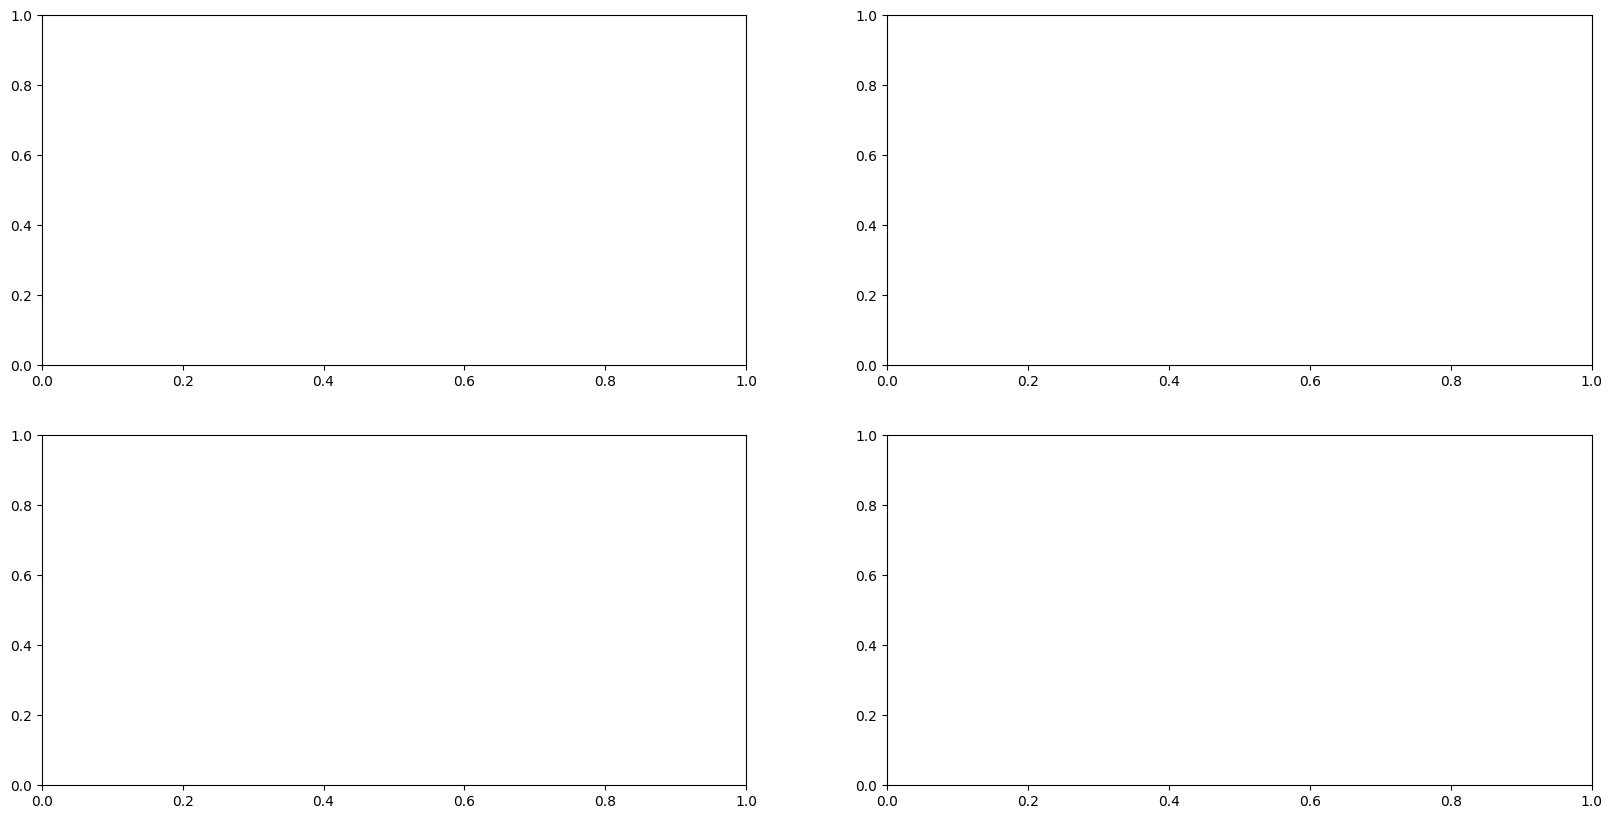

In [1]:
import numpy as np
import matplotlib.pyplot as plt

R_MARS = 3389.5

# Cell 1: Tharsis Tholus and Hecates Tholus elevation grids and profiles vs distance on Mars
regions = {
    "Tharsis Tholus": {"lon_min": 266, "lon_max": 271, "lat_min": 10, "lat_max": 20, "profile_idx": 47},
    "Hecates Tholus":   {"lon_min": 148, "lon_max": 152, "lat_min": 25, "lat_max": 40, "profile_idx": 34}
}

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
profile_data = {}

for i, (name, params) in enumerate(regions.items()):
    lon_inds = np.where((lon_mola >= params["lon_min"]) & (lon_mola <= params["lon_max"]))[0]
    lat_inds = np.where((lat_mola >= params["lat_min"]) & (lat_mola <= params["lat_max"]))[0]
    grid_region = mola_grid[np.ix_(lat_inds, lon_inds)]

    # Generate latitude array
    latitudes = np.linspace(params["lat_min"], params["lat_max"], grid_region.shape[0])
    # Compute real distances (km) from start latitude
    distance_km = (latitudes - latitudes[0]) * (np.pi/180) * R_MARS

    # Extract elevation profile
    elevation_profile = grid_region[:, params["profile_idx"]]

    # Store
    profile_data[name] = {"latitudes": latitudes,
                          "elevation_profile": elevation_profile,
                          "distance_km": distance_km}

    # Plot grid
    im = axes[0, i].imshow(
        grid_region, origin='upper', cmap='terrain',
        extent=[params["lon_min"], params["lon_max"], params["lat_min"], params["lat_max"]]
    )
    axes[0, i].set_title(f"{name} Elevation Grid")
    axes[0, i].set_xlabel("Longitude")
    axes[0, i].set_ylabel("Latitude")
    axes[0, i].axvline(x=np.linspace(params["lon_min"], params["lon_max"], grid_region.shape[1])[params["profile_idx"]],
                       color='k', linestyle='--', linewidth=2, label="Profile Line")
    axes[0, i].grid(True, linestyle=':', linewidth=0.5)
    fig.colorbar(im, ax=axes[0, i], orientation='vertical', fraction=0.046, pad=0.04).set_label("Elevation (m)")
    axes[0, i].legend()

    # Plot profile vs distance_km
    axes[1, i].plot(distance_km, elevation_profile, color='k', label="Elevation Profile")
    axes[1, i].set_title(f"{name} Elevation Profile")
    axes[1, i].set_xlabel("Distance (km)")
    axes[1, i].set_ylabel("Elevation (m)")
    axes[1, i].grid(True, linestyle=':', linewidth=0.5)
    axes[1, i].legend()

plt.tight_layout()
plt.show()

In [254]:
# Cell 2: Mean profile and individual profiles vs distance (km)
fig, axes = plt.subplots(3, 1, figsize=(15, 8))
ax1, ax2, ax3 = axes

# Mean profile distance: define your lat bounds
lat_min_mean, lat_max_mean = -20, 5
N_mean = average_elevation_profile.shape[0]
latitudes_mean = np.linspace(lat_min_mean, lat_max_mean, N_mean)
distance_mean_km = (latitudes_mean - latitudes_mean[0]) * (np.pi/180) * R_MARS

# Plot mean
ax1.plot(distance_mean_km, average_elevation_profile, color='black', linewidth=2, label='Mean Profile')
ax1.set_title('Mean Elevation Profile')
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Elevation (m)')
ax1.grid(True)
ax1.legend()

# Tharsis Tholus
dist_ascr = profile_data['Tharsis Tholus']['distance_km']
elev_ascr = profile_data['Tharsis Tholus']['elevation_profile']
ax2.plot(dist_ascr, elev_ascr, label='Tharsis Tholus', color='blue')
ax2.set_title('Tharsis Tholus')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Elevation (m)')
ax2.grid(True)
ax2.legend()

# Hecates Tholus
dist_hec = profile_data['Hecates Tholus']['distance_km']
elev_hec = profile_data['Hecates Tholus']['elevation_profile']
ax3.plot(dist_hec, elev_hec, label='Hecates Tholus', color='red')
ax3.set_title('Hecates Tholus')
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Elevation (m)')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()


In [292]:
# Cell 3: Cropped Noctis starting at 0, distinct annotation offsets

plt.figure(figsize=(12, 6))

# --- Crop & re-zero Noctis ---
left_bound  = x_mean.min() + 300
right_bound = x_mean.max() - 300
mask_mean   = (x_mean >= left_bound) & (x_mean <= right_bound)
x_mean_c    = x_mean[mask_mean] - (x_mean[mask_mean].min())
y_mean_c    = y_mean[mask_mean]

# Plot all three
plt.plot(x_mean_c, y_mean_c, label='Noctis (cropped)', color='k', linewidth=2)
plt.plot(dist_ascr, elev_ascr, label='Tharsis Tholus', color='tab:cyan', linestyle='--')
plt.plot(dist_hec,  elev_hec,  label='Hecates Tholus', color='tab:red',   linestyle='dashdot')

# Define per‐peak offsets
offsets = {
    'Noctis': (10, -15),
    'Tharsis': (-160,-20),
    'Hecates': ( -20,  -25),
}

# Annotate peaks
for x, y, label in [
    (x_mean_c, y_mean_c, 'Noctis'),
    (dist_ascr, elev_ascr, 'Tharsis'),
    (dist_hec,  elev_hec,  'Hecates')
]:
    idx = np.nanargmax(y)
    xp, yp = x[idx], y[idx]
    plt.scatter(xp, yp, marker='o', s=50)
    dx, dy = offsets[label]
    plt.annotate(f'\n{label} Peak',
                 (xp, yp),
                 textcoords='offset points',
                 xytext=(dx, dy),
                 #arrowprops=dict(arrowstyle='-'),  # optional: draw a small arrow
                 fontsize=22)

plt.title('Elevation Profiles Comparison vs Distance on Mars')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


In [215]:
import numpy as np
import matplotlib.pyplot as plt

# ── Cell 2: three-panel comparison with km distance ──
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

# Mars parameters (ensure these are defined)
R_mars = 3390.0          # km
deg2rad = np.pi / 180.0

# 1) Compute mean-profile distance
latitudes_mean = np.linspace(lat_min_mean, lat_max_mean, average_elevation_profile.size)
distance_values = (latitudes_mean - latitudes_mean[0]) * deg2rad * R_mars

# 2) Extract region distances and elevations
dist_ascr = profile_data["Tharsis Tholus"]["distance"]
elev_ascr = profile_data["Tharsis Tholus"]["elevation"]
dist_pav  = profile_data["Hecates Tholus"]["distance"]
elev_pav  = profile_data["Hecates Tholus"]["elevation"]

# 3) Plot each profile vs. km
ax1.plot(distance_values, average_elevation_profile, 'k', label='Mean Profile')
ax2.plot(dist_ascr, elev_ascr, 'b', label='Tharsis Tholus')
ax3.plot(dist_pav,  elev_pav,  'r', label='Hecates Tholus')

# 4) Titles, labels, grids, legends
for ax, title in zip((ax1, ax2, ax3),
                     ("Reconstructed Noctis Mons",
                      "Ascraeus Mons",
                      "Pavonis Mons")):
    ax.set(title=f"{title} Elevation Profile",
           xlabel="Distance (km)",
           ylabel="Elevation (m)")
    ax.legend()
    ax.grid(True, linestyle=':', linewidth=0.5)  # updated

plt.tight_layout()
plt.show()

# ── Cell 3: overplot all profiles with km distance ──
plt.figure(figsize=(12, 6))

# compute distances for lat-based profiles
lat_ascr = np.linspace(
    regions["Tharsis Tholus"]["lat_min"],
    regions["Tharsis Tholus"]["lat_max"],
    profile_data["Tharsis Tholus"]["elevation"].size)
dist_ascr = (lat_ascr - lat_ascr[0]) * deg2rad * R_mars

lat_pav = np.linspace(
    regions["Hecates Tholus"]["lat_min"],
    regions["Hecates Tholus"]["lat_max"],
    profile_data["Hecates Tholus"]["elevation"].size)
dist_pav = (lat_pav - lat_pav[0]) * deg2rad * R_mars

# plot
plt.plot(distance_values, average_elevation_profile, 'k-', lw=2, label='Noctis Mons')
plt.plot(dist_ascr, elev_ascr,               'b-', lw=2, label='Tharsis Tholus')
plt.plot(dist_pav,  elev_pav,                'r-', lw=2, label='Hecates Tholus')

plt.title("Elevation Profiles vs. Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.legend(loc='lower left')
plt.grid(True, linestyle=':', linewidth=0.5)  # updated
plt.tight_layout()
plt.show()


In [212]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})  

# ── Updated Cell 3: Overplot All Profiles without Arrow Annotations ──

# Recompute region distances
lat_ascr = np.linspace(
    regions["Tharsis Tholus"]["lat_min"],
    regions["Tharsis Tholus"]["lat_max"],
    profile_data["Tharsis Tholus"]["elevation"].size
)
dist_ascr = (lat_ascr - lat_ascr[0]) * deg2rad * R_mars

lat_pav = np.linspace(
    regions["Hecates Tholus"]["lat_min"],
    regions["Hecates Tholus"]["lat_max"],
    profile_data["Hecates Tholus"]["elevation"].size
)
dist_pav = (lat_pav - lat_pav[0]) * deg2rad * R_mars

# Plot each profile with distinct style & markers
plt.figure(figsize=(12, 6))
plt.plot(distance_values, average_elevation_profile, 
         'k-', lw=2, label='Noctis Mons')
plt.plot(dist_ascr, profile_data["Tharsis Tholus"]["elevation"], 
         'b--', lw=2, marker='o', markevery=10, label='Tharsis Tholus')
plt.plot(dist_pav, profile_data["Hecates Tholus"]["elevation"], 
         'r-.', lw=2, marker='s', markevery=10, label='Hecates Tholus')

# Annotate the peaks (text only)
for dist, elev, color, text in [
    (distance_values, average_elevation_profile, 'k', 'Noctis Peak'),
    (dist_ascr, profile_data["Tharsis Tholus"]["elevation"], 'b', 'Tharsis Peak'),
    (dist_pav, profile_data["Hecates Tholus"]["elevation"], 'r', 'Hecates Peak')
]:
    idx = np.argmax(elev)
    plt.scatter(dist[idx], elev[idx], color=color, zorder=5)
    plt.text(dist[idx] + 50, elev[idx] + 100, text, color=color, fontsize=14)

# Add zero‐elevation baseline and finer grid
plt.axhline(0, color='gray', linestyle=':', lw=1)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.minorticks_on()

# Labels, title, legend
plt.title("Elevation Profiles vs. Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


In [187]:
import numpy as np
import matplotlib.pyplot as plt

# ——————————————————————————
# 1) Make sure you have a latitude axis for your mean profile.
#    If your mean profile spans, say, lat_min_mean → lat_max_mean:
lat_min_mean, lat_max_mean =  -10, 5      # fill in your own bounds
N_mean = average_elevation_profile.shape[0]
latitudes_mean = np.linspace(lat_min_mean, lat_max_mean, N_mean)

# ——————————————————————————
# 2) Now grab your stored region data:
lat_ascr = profile_data["Tharsis Tholus"]["latitudes"]
elev_ascr = profile_data["Tharsis Tholus"]["elevation_profile"]

lat_pav  = profile_data["Hecates Tholus"]["latitudes"]
elev_pav  = profile_data["Hecates Tholus"]["elevation_profile"]

# ——————————————————————————
# 3) Plot everything together:
plt.figure(figsize=(12, 6))

plt.plot(latitudes_mean, 
         average_elevation_profile,
         label='Reconstructed Noctis Mons', color='k', linewidth=2)

plt.plot(lat_ascr,
         elev_ascr,
         label='Tharsis Tholus', color='b', linewidth=2)

plt.plot(lat_pav,
         elev_pav,
         label='Hecates Tholus', color='r', linewidth=2)

plt.title("Elevation Profiles vs Latitude")
plt.xlabel("Latitude (°)")
plt.ylabel("Elevation (m)")
plt.legend(loc = 'lower left')
plt.grid(True, linestyle=':', linewidth=1)
plt.tight_layout()
plt.show()

## Volume 

We will calucalte volume using the thickness grid/uplift grid as that represents the close approximation to height of the Noctis Mons bulge. As just using the raised grid wouldnt really give us god estimate of the volume since the elelvations for individual grids are measured from a base level while thickness would be a good height estimate for how much height we are intereste din while considering volume. 

In [273]:
pyro_elevation = 1500
mask_pyro = (uplift_grid > pyro_elevation) & (grid_x < 267)

# version you can sum (or integrate) directly:
uplift_grid_1 = np.where(mask_pyro, uplift_grid, 0.0)



#we want area grid to match in resolution with the thickness/uplift grid which can be controlled by 'n' 
n = uplift_grid_1.shape[0]/2
n = int(n)
print (f'n that determines resolution = {n}')
Mars_MOLA = pysh.datasets.Mars.MOLA_shape().expand() #after expnasion the deafult grid range is 0-360 in longitude 
R_Mars = 3389.5 #kms
step = 360 / (2*Mars_MOLA.n)
#grid_lon, grid_lat = np.meshgrid(Mars_MOLA.lons(), Mars_MOLA.lats())
grid_lon = grid_x
grid_lat = grid_y
area_uplifted_grid = R_Mars**2 * np.sin((grid_lat+90) * np.pi/180) * step * np.pi/180 * step * np.pi/180 #should be km2
total_area  = np.sum(area_uplifted_grid) #in km2
print (f'shape of the area_uplifted grid {area_uplifted_grid.shape} columns and rows')
print (f'total area of  the uplifted region: {total_area} km2')
volume_grid = area_uplifted_grid*(uplift_grid_1/1000)  #in km3
total_volume = np.sum(volume_grid) # use [circular mask]
print(f'The volume of the uplifted region of Noctis Mons will be : {total_volume} km3\n note that this is not the volume of the Nocti Mons itself but the region that is uplifted')

n that determines resolution = 87
shape of the area_uplifted grid (175, 86) columns and rows
total area of  the uplifted region: 816558.0858037819 km2
The volume of the uplifted region of Noctis Mons will be : 751023.1682997576 km3
 note that this is not the volume of the Nocti Mons itself but the region that is uplifted


## Volume comparison: 
    
- The volume of the uplifted region of Noctis Mons will be : 1.8 million km3
    - note that this is not the volume of the Nocti Monss itself but the region that is uplifted

#### Major Martian Volcanoes and Their Volumes
- Pavonis Mons 14 km tall (~250,000 km³)
    - One of the Tharsis Montes volcanoes
- Ascraeus Mons (~1.2 million km³)
- Alba Mons (~2.5 million km³)
- Olympus Mons (~4 million km³)


<IPython.core.display.Javascript object>


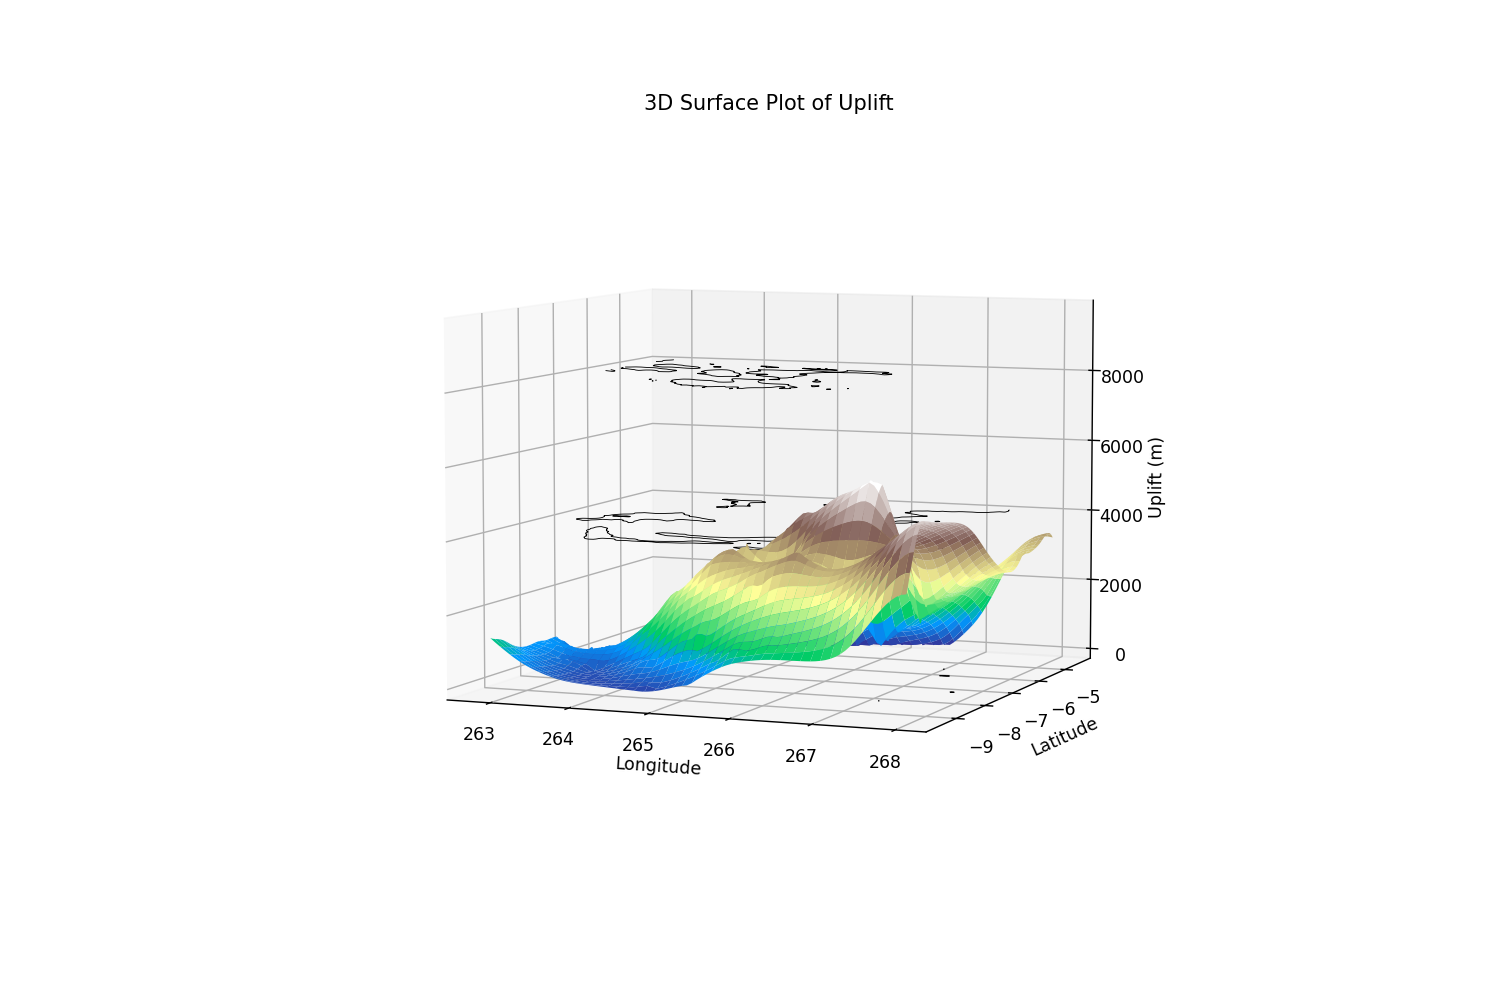

In [28]:
#use the corrected uplift grid here instead 

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_lon, grid_lat, uplift_grid, cmap='terrain')
ax.contour(grid_x, grid_y, grid_noctis_rect_elevation, levels=2, colors='black', linewidths=0.5)
ax.set_title('3D Surface Plot of Uplift')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Uplift (m)')
plt.show()


## Insertion (2): Modified --> the Interpolated highs - interpolated base grid into the pre-noctis interpolated grid that is the "grid_noctis_filled" grid after interpolation. 

In [ ]:
###-------Obtaining the difference grid------#

base_layer = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\base elevations_2.shp")
raised_layer = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\raised elevations_2.shp") 

#.values attribute returns a NumPy array containing just the values without any associated index or column information from the DataFrame or Series.
#essentially without the values attribute we will be extracting the all the associated informaiton in th table like column, data type etc

x_b = base_layer['X'].values+360
y_b = base_layer['Y'].values
z_b = base_layer['elevations'].values


#---------Interpolation--------#

grid_x_b, grid_y_b = np.meshgrid (
    np.linspace(min(x_b), max(x_b), np.shape(grid_noctis_cropped)[1]),   
    np.linspace(min(y_b), max(y_b), np.shape(grid_noctis_cropped)[0]))
# Radial Basis Function (RBF) interpolation (Spline)
rbf_interpolator_b = Rbf(x_b, y_b, z_b, function='linear') #-->input is known coordinates, known elevation
grid_z_spline_b = rbf_interpolator_b(grid_x_b, grid_y_b) #input required coordinates, outputs the required elevation 

#---------Interpolation--------#
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), np.shape(grid_noctis_cropped)[1]),       
    np.linspace(min(y), max(y), np.shape(grid_noctis_cropped)[0]))
# Radial Basis Function (RBF) interpolation (Spline)

rbf_interpolator = Rbf(x, y, z, function='linear')
grid_z_spline_r = rbf_interpolator(grid_x, grid_y)



#------Difference--------#
difference_grid = grid_z_spline_r- grid_z_spline_b

plt.imshow(difference_grid)
plt.colorbar()


b. Inserting the difference grid into the inteprolated grid of prenoctis (after low resolution RBF interpolation) 
remember not inton the grid_noctis_rectangular_masked because that has an empty space in the middle, what we want instead is to add on top of a pre-noctis plane which is grid_noctis_filled_lr. But perhaps we can get the high_res pre-noctis to add the raise-low on top of it?

In [ ]:
print("Shape of the difference grid:", difference_grid.shape)
print("Shape of target region:", grid_noctis_filled_lr[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max].shape)
#this proves that the shape of the extracted grid matches with the region where we want to insert it back 

inserted_composite = grid_noctis_filled_lr.copy()  # create a new grid
###-------------Very important difference-------###
#inserted_composite[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max] = difference_grid 
# we do not use this here since this uses = which means this overwrites the data in that region. 
#If you want to add the values from difference_grid to the existing values of grid_noctis_filled, you need to use the += operator

# Insert the difference_grid into the composite grid at the specified region
inserted_composite[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max] += difference_grid

##-----Now the inserted_composite grid has the differenced grid added on top of the pre-Noctis interpolated region!

print (inserted_composite.shape)

plt.figure(figsize=(20,10))
im1 = plt.imshow(inserted_composite, origin='upper', cmap='terrain',
                    extent=[lon_min, lon_max, lat_min, lat_max]) #extent of the larger subgrid
#geological context from the present day map (which in this case we will need to define a new grid for present day topography as grid_noctis_2000 is larger and of different shape)
plt.contour(grid_x, grid_y, grid_noctis_rect_elevation, levels= 1, colors = 'k', origin = 'upper')
plt.scatter(x, y, c='r', s=0.3)
plt.colorbar(im1)
print (f'maximum value of the difference (rasied-base) grid {np.max(difference_grid)} meters')


In [ ]:
# Define Azimuth Angles for Profiles
azimuths = np.linspace(0, 180, num=35) #15 profiles between 0 and 180 equally spaced angles 
length = 1000 #(in grid in units)  

#let us try to remove the angles passing thrugh valles marineris for better constraint on heights
# Remove angles in the range [0, 70]
azimuths = azimuths[(azimuths < 0) | (azimuths > 70) & (azimuths < 115) | (azimuths > 180)]

elevation_profiles = []  # List to store profiles

plt.figure(figsize=(12, 6))
im1 = plt.imshow(inserted_composite, origin='upper', cmap='terrain', extent=[lon_min, lon_max, lat_min, lat_max])
plt.contour(grid_x, grid_y, grid_noctis_rect_elevation, levels= 1, colors = 'k', origin = 'upper')
plt.scatter(x, y, c='r', s=0.1)

#need to redefined the noctis_centre_x and noctis_centre_y since longitudes_extent is different from longitudes_extent

noctis_center_lon = -94.60 + 360  #manually seelcted from the map
noctis_center_lat = -7.05 
# these are geographical coordinates, needed to be referenced in the Grid
noctis_center_x = np.argmin(np.abs(longitudes_extent - noctis_center_lon)) #this will give the centre's index of longitude in the grid
noctis_center_y = np.argmin(np.abs(latitudes_extent - noctis_center_lat))


# Loop through each azimuth to compute and plot profiles
for angle in azimuths:
    dx = length * np.cos(np.radians(angle))
    dy = length * np.sin(np.radians(angle))
    
    x_start = int(noctis_center_x - dx / 2)
    y_start = int(noctis_center_y - dy / 2)
    x_end = int(noctis_center_x + dx / 2)
    y_end = int(noctis_center_y + dy / 2)
    
    
    x_indices_profile = np.clip(np.linspace(x_start, x_end, num=length), 0,  inserted_composite.shape[1] - 1).astype(int)
    y_indices_profile = np.clip(np.linspace(y_start, y_end, num=length), 0, inserted_composite.shape[0] - 1).astype(int)
    
    elevation_profile = inserted_composite[y_indices_profile, x_indices_profile]
    elevation_profiles.append(elevation_profile)  # Store profile
    
    # Plot profile on the map
    plt.plot(longitudes_extent[x_indices_profile], latitudes_extent[y_indices_profile], linewidth=1.5, linestyle='--', label=f"{angle:.1f}°")

plt.legend(markerscale=0.4, fontsize=8)
plt.title("Elevation Profiles (after inserting difference(of highs-lows) grid in prenoctis plane)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im1, label="Elevation", location = 'left')
plt.show()

# Convert to NumPy array
elevation_profiles = np.array(elevation_profiles)

# Compute Mean Elevation Profile
average_elevation_profile = np.mean(elevation_profiles, axis=0)

# Plot Elevation Profiles
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Individual Elevation Profiles
for i, angle in enumerate(azimuths):
    axes[0].plot(longitudes_extent[x_indices_profile], elevation_profiles[i], linewidth=1.5, label=f'{angle:.1f}°')

axes[0].set_ylabel("Elevation (m)")
axes[0].set_title("Elevation Profiles along Different Azimuths")
axes[0].grid(True)

# Mean Elevation Profile
axes[1].plot(longitudes_extent[x_indices_profile], average_elevation_profile, color='black', linewidth=2, label='Mean Profile')
axes[1].fill_between(longitudes_extent[x_indices_profile], average_elevation_profile, alpha=0.2, color='gray')
axes[1].set_ylabel("Elevation (m)")
axes[1].set_title("Mean Elevation Profile (after inserting difference(of highs-lows) grid in prenoctis plane)")
axes[1].grid(True)

# Shade the region in the elevation profile
axes[1].axvspan(highlight_min, highlight_max, color='red', alpha=0.2, label="Presnt day larger uplift bounds)")
#axes[1].set_ylim(0, 10000)
axes[0].axvspan(highlight_min, highlight_max, color='red', alpha=0.2, label="Presnt day larger uplift bounds")

axes[0].legend(fontsize=8)
axes[1].legend(fontsize=8)


plt.tight_layout()
plt.show()

